## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../MCMC')

In [2]:
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable, Function

In [3]:
import batch_utils
import plot_utils
import McNeuron

## Data

In [31]:
training_data = McNeuron.NeuronCollection.load_data('/Users/pavanramkumar/Dropbox/HG-GAN/03-Data/All Data/')

In [5]:
# import pickle
# training_data = pickle.load(open('/Users/pavanramkumar/Dropbox/HG-GAN/03-Data/pyramidal_neuron_n40_parent_id.p', 'rb'))

In [6]:
# n_nodes = 40
# g = training_data['geometry']['n'+str(n_nodes)]
# m = training_data['morphology']['n'+str(n_nodes)]
# n_samples = g.shape[0]

# not_nan_list = list()
# for n in range(n_samples):
#     if ~np.any(np.isnan(g[n])):
#         not_nan_list.append(n)
# not_nan_list = np.array(not_nan_list)
# g = g[not_nan_list, :, :]
# m = m[not_nan_list, :]
# training_data['geometry']['n'+str(n_nodes)] = g
# training_data['morphology']['n'+str(n_nodes)] = m

In [120]:
example_neuron = McNeuron.Neuron(input_file=training_data['X'][0][:, :],
                                 input_format="Matrix of swc")

In [121]:
print example_neuron.branch_order.shape
print example_neuron.location.shape

(408,)
(3, 408)


In [42]:
z = example_neuron.location[:, 0]

In [50]:
training_data['X'][0].shape[0]

408

In [51]:
n_nodes = list()
for i in range(len(training_data['X'])):
    n_nodes.append(training_data['X'][i].shape[0])
n_nodes = np.array(n_nodes)

In [104]:
np.sum(n_nodes <= 5000) / np.float(n_nodes.shape[0])

0.94552424957728554

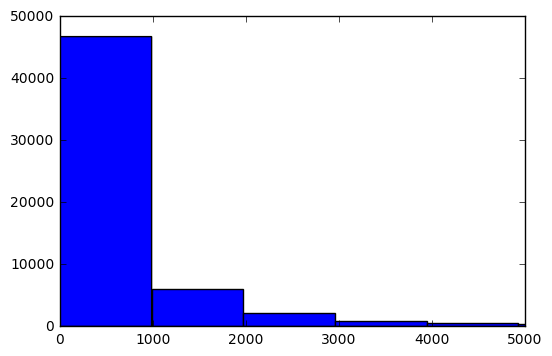

In [58]:
plt.hist(n_nodes, 125)
plt.xlim([0, 5000])
plt.show()

In [106]:
from collections import Counter
print Counter(training_data['Y']['Secondary Cell Class'])
# print np.sort(Counter(training_data['Y']['Secondary Cell Class']).values())[::-1]

Counter({'pyramidal': 14013, 'Unknown neurotransmitter': 7237, 'Not reported': 6670, 'glutamatergic': 6092, 'GABAergic': 4474, 'cholinergic': 3384, 'granule': 2308, 'serotonergic': 2212, 'Nitrergic': 2044, 'medium spiny': 1534, 'ganglion': 1485, 'dopaminergic': 870, 'basket': 542, 'Motoneuron': 407, 'Parachromaffin': 401, 'tangential': 338, 'Aspiny': 327, 'octopaminergic': 265, 'uniglomerular projection': 237, 'transmedulla': 235, 'stellate': 214, 'Multidendritic-dendritic arborization (DA)': 211, 'Pyramidal-like': 192, 'somatic': 184, 'Martinotti': 148, 'projection': 147, 'direction sensitive': 127, 'astrocyte': 117, 'Parvalbumin (PV)-positive': 110, 'neurogliaform': 106, 'Type I': 91, 'prion protein (PrP) promoter-positive': 81, 'Fast-spiking': 79, 'Oligodendrocyte': 78, 'Neuropeptide Y (NPY)-positive': 77, 'Cajal-Retzius': 73, 'olivocerebellar': 68, 'Intersubnuclear neuron': 68, 'bitufted': 67, 'Type II': 65, 'thalamocortical': 65, 'bipolar': 64, 'ivy/neurogliaform': 58, 'Golgi': 56

## Pseudo code

In [125]:
dim = 100
# random_projection = np.random.randn(dim, 3)
random_projection = np.eye(3, 3)

In [126]:
def encode_node(neuron, node, random_projection):
    z = neuron.location[:, node]
    z = np.dot(random_projection, z)
    return z

In [127]:
def continue_reduce(z1, z2, context):
    return z1 + z2 + context

In [128]:
def branch_reduce(z1, z2, z3, context):
    return z1 + z2 + z3 + context

In [129]:
def tracker(context, z, buffer_):
    next_context = np.tanh(context + np.mean(z1) + np.mean(buffer_))
    return next_context

In [148]:
node = example_neuron.branch_order.shape[0] - 1
stack = list()
# stack.append(encode_node(example_neuron, node, random_projection))
context = 0.

while (node >= 1):
    
    # Read buffer
    z_buffer = encode_node(example_neuron, node, random_projection)
    
    # Update tracker
    context = 0. # tracker(context, stack[-1], z1)
    
    # Leaf node
    if(example_neuron.branch_order[node] == 0):
        stack.append(z_buffer)
        
    # Node with one parent
    if(example_neuron.branch_order[node] == 1):
        z_stack1 = stack.pop()
        z = continue_reduce(z_buffer, z_stack1, context)
        stack.append(z)
        
    # Node with two parents
    if(example_neuron.branch_order[node] == 2):
        z_stack1 = stack.pop()
        z_stack2 = stack.pop()
        z = branch_reduce(z_buffer, z_stack1, z_stack2, context)
        stack.append(z)
        
    node-=1

z_buffer = encode_node(example_neuron, node, random_projection)
stack.append(z_buffer)

while len(stack) > 1:
    context = 0. # tracker(context, stack[-1], z1)
    
    if len(stack) > 2:
        z1 = stack.pop()    
        z2 = stack.pop()
        z3 = stack.pop()
        z = branch_reduce(z1, z2, z3, context)
        stack.append(z)
    else:
        z1 = stack.pop()
        z2 = stack.pop()
        z = continue_reduce(z1, z2, context)
        stack.append(z)

In [149]:
stack = np.array(stack)
print stack

[[ -7544.89  19066.11    114.12]]


In [150]:
np.sum(example_neuron.location, axis=1)

array([ -7544.89,  19066.11,    114.12])

In [174]:
tmp = np.pad(example_neuron.location, ((0, 0), (0, 10)), 'constant', constant_values=-999.)

In [175]:
print example_neuron.location.shape
print tmp.shape

(3, 408)
(3, 418)


In [176]:
tmp = np.pad(example_neuron.branch_order, (0, 10), 'constant', constant_values=-1)

In [181]:
print example_neuron.branch_order.shape
print tmp.shape
print tmp[-11]

(408,)
(418,)
0.0


## Global parameters

In [29]:
n_nodes = 40
input_dim = 100
train_iters = 5000
batch_size = 32
d_iters = 10
lr_discriminator =  0.0005
lr_generator = 0.01
# train_loss = 'binary_crossentropy'
train_loss = 'wasserstein_loss'

rule = 'none'
d_clip = 0.05

## Layers

In [4]:
def bundle(x):
    return torch.t(torch.stack([x_ for x_ in x], 1)).squeeze()
    # return torch.t(torch.stack([x_.pop() for x_ in x], 1)).squeeze()

def unbundle(x):
    if x is None:
        return itertools.repeat(None)
    return torch.split(torch.cat(x, 1), 1, 0)

### Reduce

In [6]:
def continue_lstm(stack1, buf, lstm_in):
    u_, input_, forget_stack1_, forget_buf_, output_ = lstm_in.chunk(5, 1)
    c = input_.sigmoid() * u_.tanh() + \
        forget_stack1_.sigmoid() * stack1 + \
        forget_buf_.sigmoid() * buf
    h = output_.sigmoid() * c.tanh()
    # print '(h, c)', h.size(), c.size()
    return torch.cat([h.unsqueeze(2), c.unsqueeze(2)], 1)

In [7]:
def branch_lstm(stack1, stack2, buf, lstm_in):
    u_, input_, forget_stack1_, forget_stack2_, forget_buf_, output_ = lstm_in.chunk(6, 1)
    c = input_.sigmoid() * u_.tanh() + \
        forget_stack1_.sigmoid() * stack1 + \
        forget_stack2_.sigmoid() * stack2 + \
        forget_buf_.sigmoid() * buf
    h = output_.sigmoid() * c.tanh()
    # print '(h, c)', h.size(), c.size()
    return torch.cat([h.unsqueeze(2), c.unsqueeze(2)], 1)

In [149]:
class Reduce1(torch.nn.Module):
    
    def __init__(self, dim, tracker_dim):
        super(Reduce1, self).__init__()
        self.dim = dim
        self.tracker_dim = dim
        self.stack1 = torch.nn.Linear(dim, 5 * dim)
        self.buf = torch.nn.Linear(dim, 5 * dim, bias=False)
        self.track = torch.nn.Linear(tracker_dim, 5 * dim, bias=False)
            
    def forward(self, stack1, buf, context):
        if len(stack1) > 1:
            stack1_, buf_ = bundle(stack1), bundle(buf)
        else:
            stack1_, buf_ = \
                stack1[-1].view(1, 2 * self.dim), buf[-1].view(1, 2 * self.dim)
            print stack1[-1].size()
            print stack1_.size()
        if len(context) > 1:
            context_ = bundle(context)
        else:
            context_ = context[-1].view(1, 2 * self.tracker_dim)
        lstm_in = self.stack1(stack1_[:, :self.dim])
        lstm_in += self.buf(buf_[:, :self.dim])
        lstm_in += self.track(context_[:, :self.dim])
        out = continue_lstm(stack1_[:, self.dim:], buf_[:, self.dim:], lstm_in)
        print 'output of reduce1 is list of length', len(out), 'containing', out[0].size()
        return out

In [150]:
class Reduce2(torch.nn.Module):
    
    def __init__(self, dim, tracker_dim):
        super(Reduce2, self).__init__()
        self.dim = dim
        self.tracker_dim = dim
        self.stack1 = torch.nn.Linear(dim, 6 * dim)
        self.stack2 = torch.nn.Linear(dim, 6 * dim, bias=False)
        self.buf = torch.nn.Linear(dim, 6 * dim, bias=False)
        self.track = torch.nn.Linear(tracker_dim, 6 * dim, bias=False)
            
    def forward(self, stack1, stack2, buf, context):
        if len(stack1) > 1:
            stack1_, stack2_, buf_ = bundle(stack1), bundle(stack2), bundle(buf)
        else:
            stack1_, stack2_, buf_ = \
                stack1[-1].view(1, 2 * self.dim), stack2[-1].view(1, 2 * self.dim), buf[-1].view(1, 2 * self.dim)
        context_ = bundle(context)
        lstm_in = self.stack1(stack1_[:, :self.dim])
        lstm_in += self.stack2(stack2_[:, :self.dim])
        lstm_in += self.buf(buf_[:, :self.dim])
        lstm_in += self.track(context_[:, :self.dim])
        out = branch_lstm(stack1_[:, self.dim:], stack2_[:, self.dim:], buf_[:, self.dim:], lstm_in)
        print 'output of reduce2 is list of length', len(out), 'containing', out[0].size()
        return out

### Tracker

In [151]:
class Tracker(torch.nn.Module):
    
    def __init__(self, dim, tracker_dim):
        super(Tracker, self).__init__()
        self.rnn = torch.nn.LSTMCell(4 * dim, tracker_dim)
        self.dim = dim
        self.tracker_dim = tracker_dim
        self.context = None 
        
    def reset_state(self):
        self.context = None

    def forward(self, bufs, stacks):
        buf = torch.t(torch.stack([buf[-1] for buf in bufs], 1).squeeze())
        stack1 = torch.t(torch.stack([stack[-1] for stack in stacks], 1).squeeze())
        x = torch.cat((stack1, buf), 1)
        batch_size = x.size(0)
        if self.context is None:
            self.context = 2 * [Variable(torch.zeros(batch_size, self.tracker_dim))]
        self.context = self.rnn(x, self.context)
        res = unbundle(self.context)
        print 'output of tracker is list of length', len(res), 'containing', res[0].size()
        return unbundle(self.context)

## Models

### NodeEncoder [node2vec]

In [152]:
class NodeEncoder(torch.nn.Module):
    
    def __init__(self, input_dim=3, hidden_dim=25, output_dim=100):
        super(NodeEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h_ = self.linear1(x)
        h_ = torch.nn.Softsign()(h_)
        h_ = self.linear2(h_)
        c_ = Variable(torch.zeros(h_.size()))
        y_pred = torch.cat([h_, c_], 1)
        return y_pred

### TreeEncoder [tree2vec]

In [194]:
class TreeEncoder(torch.nn.Module):
    
    def __init__(self,
                 dim=100,
                 tracker_dim=100,
                 node_input_dim=3,
                 node_hidden_dim=25):
        super(TreeEncoder, self).__init__()
        self.dim = dim
        self.tracker_dim = tracker_dim
        self.reduce1 = Reduce1(dim, tracker_dim)
        self.reduce2 = Reduce2(dim, tracker_dim)
        self.tracker = Tracker(dim, tracker_dim)
        self.encoder = NodeEncoder(node_input_dim, node_hidden_dim, dim)
        
    def forward(self, buffers, commands):
        encoded_buffers = [torch.t(self.encoder(torch.stack([buf for buf in buff], 0).squeeze())) for buff in buffers]
        encoded_buffers = [list(buf.chunk(buf.size(1), 1)) for buf in encoded_buffers]
        
        # Initialize stack
        stacks = [[buf[0]] for buf in encoded_buffers]

        # Reset tracker state
        self.tracker.reset_state()

        # Loop through nodes
        node = np.max([len(com) for com in commands])
        while (node >= 1):

            print node
            # Update tracker states
            tracker_states = self.tracker(encoded_buffers, stacks)
            
            stack00, stack11, stack21, stack22, = [], [], [], []
            bufs1, bufs2, trackings1, trackings2 = [], [], [], []
            batch = zip(commands, encoded_buffers, stacks, tracker_states)
            for com, buf, stack, tracking in batch:    
                if len(buf) > 0:
                    # Read buffer and command
                    b, c = buf.pop(), com[-1]
                    print b.size()
                    if c.data.numpy()[0] == 0:  # leaf node
                        stack00.append(b)

                    elif c.data.numpy()[0] == 1:  # node with one parent (continuation)
                        bufs1.append(b)
                        stack11.append(stack.pop())
                        trackings1.append(tracking)

                    elif c.data.numpy()[0] == 2: # node with two parents (branching)
                        bufs2.append(b)
                        stack21.append(stack.pop())
                        stack22.append(stack.pop())
                        trackings2.append(tracking)

            if stack00:
                print 'shift'
                reduced0 = iter(stack00)
                for com, stack in zip(commands, stacks):
                    c = com[-1]
                    if c.data.numpy()[0] == 0:
                        com.pop()
                        stack.append(next(reduced0))
                        print 'stack length = ', len(stack)
            if stack11:
                print 'reduce1'
                print '---------'
                print '# reduce1 ops in this batch =', len(stack11)
                reduced1 = iter(self.reduce1(stack11, bufs1, trackings1))
                omg = 1
                for com in commands:
                    c = com[-1]
                    if c.data.numpy()[0] == 1:
                        omg += 1
                for com, stack in zip(commands, stacks):
                    c = com[-1]
                    if c.data.numpy()[0] == 1:
                        com.pop()
                        stack.append(next(reduced1))
                        print 'stack length = ', len(stack)
            if stack22:
                print 'reduce2'
                reduced2 = iter(self.reduce2(stack21, stack22, bufs2, trackings2))
                for com, stack in zip(commands, stacks):
                    c = com[-1]
                    if c.data.numpy()[0] == 2:
                        com.pop()
                        stack.append(next(reduced2))
                        print 'stack length = ', len(stack)
            node -= 1

        # Process the remaining items in the stack
        print 'processing remaining items in the stack'
        
        while(1):
            stack11, stack21, stack22, = [], [], []
            bufs1, bufs2, trackings1, trackings2 = [], [], [], []
        
            for stack, tracking in zip(stacks, tracker_states):
                if len(stack) > 2:
                    bufs1.append(stack.pop())
                    stack11.append(stack.pop())
                    trackings1.append(tracking)
                elif len(stack) > 3:
                    bufs2.append(stack.pop())
                    stack21.append(stack.pop())
                    stack22.append(stack.pop())
                    trackings2.append(tracking)
                    
            if stack11:
                reduced1 = iter(self.reduce1(stack11, bufs1, trackings1))
                for com, stack in zip(commands, stacks):  # this logic won't work (coms are empty)
                    if com == 1:
                        stack.append(next(reduced1))
            elif stack22:
                reduced2 = iter(self.reduce2(stack21, stack22, bufs2, trackings2))
                for com, stack in zip(commands, stacks): # this logic won't work (coms are empty)
                    if com == 2:
                        stack.append(next(reduced2))
            else:
                break

        return torch.t(torch.stack([stack.pop() for stack in stacks], 1)).squeeze()
        # return stacks

### Classifier

In [195]:
class Classifier(torch.nn.Module):
    
    def __init__(self, input_dim=100, n_classes=5):
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.linear1 = torch.nn.Linear(input_dim, 100)
        self.linear2 = torch.nn.Linear(100, 50)
        self.linear3 = torch.nn.Linear(50, 10)
        self.linear4 = torch.nn.Linear(10, n_classes)
        
    def forward(self, x):
        h_ = self.linear1(x)
        h_ = torch.nn.Softsign()(h_)
        h_ = self.linear2(h_)
        h_ = torch.nn.Softsign()(h_)
        h_ = self.linear3(h_)
        h_ = torch.nn.Softsign()(h_)
        h_ = self.linear4(h_)
        h_ = torch.nn.Softmax()(h_)
        y_pred = h_
        return y_pred

### Test APIs

#### Dummy data

In [196]:
T = TreeEncoder(dim=100,
                tracker_dim=100,
                node_input_dim=3,
                node_hidden_dim=25)
D = Classifier(input_dim=100,
               n_classes=5)

buffers = [Variable(torch.randn(3, 11)),
           Variable(torch.randn(3, 11)),
           Variable(torch.randn(3, 11))]
buffers = [list(buf.chunk(buf.size(1), 1)) for buf in buffers]

command1 = Variable(torch.Tensor([2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 0]))
command2 = Variable(torch.Tensor([2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 0]))
command3 = Variable(torch.Tensor([2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 0]))
commands = [command1, command2, command3]
commands = [list(com.split(1)) for com in commands]

z = T(buffers, commands)
d = D(z[:, :input_dim])

print z.size() , d.size()

11
output of tracker is list of length 3 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
shift
stack length =  2
stack length =  2
stack length =  2
10
output of tracker is list of length 3 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
shift
stack length =  3
stack length =  3
stack length =  3
9
output of tracker is list of length 3 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
reduce2
output of reduce2 is list of length 3 containing torch.Size([200, 1])
stack length =  2
stack length =  2
stack length =  2
8
output of tracker is list of length 3 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
shift
stack length =  3
stack length =  3
stack length =  3
7
output of tracker is list of length 3 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
reduce1
out

#### Real data

In [197]:
neuron0 = McNeuron.Neuron(input_file=training_data['X'][0][:, :],
                          input_format="Matrix of swc")

neuron1 = McNeuron.Neuron(input_file=training_data['X'][2][:, :],
                          input_format="Matrix of swc")


buffers = [Variable(torch.Tensor(neuron0.location)),
           Variable(torch.Tensor(neuron1.location))]
buffers = [list(buf.chunk(buf.size(1), 1)) for buf in buffers]

commands = [Variable(torch.Tensor(neuron0.branch_order)),
            Variable(torch.Tensor(neuron1.branch_order))]

commands = [list(com.split(1)) for com in commands]

z = T(buffers, commands)
d = D(z[:, :input_dim])

print z.size() , d.size()

715
output of tracker is list of length 2 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
shift
stack length =  2
stack length =  2
714
output of tracker is list of length 2 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
reduce1
output of reduce1 is list of length 2 containing torch.Size([200, 1])
2 2
c =  Variable containing:
 1
[torch.FloatTensor of size 1]

stack length =  2
c =  Variable containing:
 1
[torch.FloatTensor of size 1]

stack length =  2
713
output of tracker is list of length 2 containing torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])
shift
stack length =  3
reduce1
torch.Size([200, 1])
torch.Size([1, 200])
output of reduce1 is list of length 1 containing torch.Size([200, 1])
2 2
c =  Variable containing:
 1
[torch.FloatTensor of size 1]

stack length =  2
c =  Variable containing:
 1
[torch.FloatTensor of size 1]



StopIteration: 

In [180]:
commands[0][-1].data.numpy()[0]

1.0

## Training

In [69]:
def reset_grad(nets):
    for net in nets:
        net.zero_grad()

In [198]:
G_params = (list(G_shared.parameters()) + list(Gg.parameters()) + list(Gm.parameters()))

G_solver = optim.RMSprop(G_params, lr=lr_generator)
D_solver = optim.RMSprop(D.parameters(), lr=lr_discriminator)

for it in range(train_iters):
    list_d_loss = list()
    for _ in range(d_iters):
        
        # Sample real data from training set
        g_real, m_real = next(batch_utils.get_batch(training_data,
                                                    batch_size,
                                                    n_nodes))
        x_real = np.concatenate((g_real, m_real), 2)
        x_real = x_real.astype(float)
        x_real = Variable(torch.Tensor(x_real), requires_grad=True)

        # Sample fake data from generators
        z = Variable(torch.randn(batch_size, input_dim))
        g_fake, m_fake = Gg(G_shared(z)), Gm(G_shared(z))
        x_fake = torch.cat([g_fake, m_fake], 2)
        
        # Train discriminator [forward-loss-backward-update]
        d_real, d_fake = D(x_real), D(x_fake)
        d_loss = -(torch.mean(d_real) - torch.mean(d_fake))
        d_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-d_clip, d_clip)

        # Housekeeping
        list_d_loss.append(d_loss.data.numpy()[0])
        nets = [G_shared, Gg, Gm, D]
        reset_grad(nets)
        
    # Sample fake data from generators
    z = Variable(torch.randn(batch_size, input_dim))
    g_fake, m_fake = Gg(G_shared(z)), Gm(G_shared(z))
    x_fake = torch.cat([g_fake, m_fake], 2)        
    d_fake = D(x_fake)

    # Train generators [forward-loss-backward-update]
    g_loss = -torch.mean(d_fake)
    g_loss.backward()
    
    for p in G_shared.parameters():
        p.grad.data = 0.5 * p.grad.data
    
    G_solver.step()

    # Housekeeping
    nets = [S, G, M, D]
    reset_grad(nets)

    print(d_loss.data.numpy())
    print(g_loss.data.numpy())

    neuron_object = \
        plot_utils.plot_example_neuron_from_parent(
            g_real[0, :, :],
            m_real[0, :, :])

    neuron_object = \
        plot_utils.plot_example_neuron_from_parent(
            g_fake.data.numpy()[0, :, :],
            m_fake.data.numpy()[0, :, :])
        
    plt.plot(np.squeeze(g_fake.data.numpy()[0, :, :]))

    plot_utils.plot_adjacency(m_real[0:2, :, :],
                              m_real[0:2, :, :],
                              m_fake.data.numpy()[0:2, :, :])

    plot_utils.plot_loss_trace(list_d_loss)


NameError: name 'G_shared' is not defined

In [61]:
eps = Variable(torch.rand(batch_size, 1))
# x_inter = eps * x_real + (1. - eps) * x_fake
x_inter = x_real
grad = torch.grad(D(x_inter), [x_inter])
grad_norm = torch.sqrt(torch.sum((grad) ** 2, 1))
grad_pen = lam * torch.mean(grad_norm - 1.) ** 2

AttributeError: 'module' object has no attribute 'grad'